In [7]:
from functions import *
import matplotlib.pyplot as plt
import scipy.optimize as op
from scipy.integrate import odeint
import camb
from camb import model, initialpower

In [8]:
#%% fitting to obtain numerical solution for recomb rate
#initial guess
a_guess = np.array([2e-13, 0.8])
#initialise values for recomb coefficient
z = np.linspace(800, 1700, 1000)
a_data = a_ex(z)

fit_a, cov_a = op.curve_fit(exp_fit, z, a_data, a_guess)

In [16]:
#function components of rate of X
def C(z,X):
    C1 = 1+Lambda*K(z)*(1-X)*ng(z)*eta
    C2 = 1+Lambda*K(z)*(1-X)*ng(z)*eta*(Lambda+b_over_a(z)*exp_fit(z, fit_a[0], fit_a[1]))
    return C1/C2
def rate_a(z, X):
    return exp_fit(z, fit_a[0], fit_a[1])*X*X*eta*ng(z)
def rate_b(z, X):
    return b_over_a(z)*exp_fit(z, fit_a[0], fit_a[1])*np.exp(-ly/Temp(z))*(1-X)

#general dx/dz
def X_diff(z,X, approx = False):
    prefactor = 1/((1+z)*Hubble(z))
    if approx == False:
        return prefactor*(rate_a(z, X)-rate_b(z, X))*C(z, X)
    else:
        return prefactor*rate_a(z, X)*C(z, X)
    
#dx/dz using approximations in vol3
def X_vol3(z,X):
    prefactor = 1/((1+z)*Hubble(z))
    a = exp_fit(z, fit_a[0], fit_a[1])
    return prefactor*rate_a(z, X)/(1+b_over_a(z)*exp_fit(z, fit_a[0], fit_a[1])/Lambda)

#solving differential equation of dx/dz
def solve(func, y0, t0, tf, N, give_t, *args):
    t = np.linspace(t0, tf, N)
    sol_y = odeint(func, y0, t, tfirst = True, args = args)
    if give_t == False:
        return sol_y[:,0]
    else:
        return sol_y[:,0], t

In [10]:
#get camb parameters
pars=camb.CAMBparams()
pars.set_cosmology(70)
pars.InitPower.set_params(2e-9,0.965,0)
pars.set_for_lmax(2000)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit = 'muK')
pars = camb.set_params(H0=67.3, ombh2=0.02207, omch2=0.1198, As=2e-9, ns=0.95)
data= camb.get_background(pars)

In [17]:
trunc = np.linspace(800, 1200, 100)
review_fit = rev_ex(trunc)
approx, z = solve(X_diff, 1, 1700, 800, 1000, True, True)
full = solve(X_diff, 1, 1700, 800, 1000, False, False)
vol3 = solve(X_vol3, 1, 1700, 800, 1000, False)
back_ev = data.get_background_redshift_evolution(z, ['x_e', 'visibility'], format='array')
cmb = back_ev[:,0]

In [14]:
#approx, z = solve(X_diff, saha(800), 800, 1400, 1000, True, True)
#full = solve(X_diff, saha(800), 800, 1400, 1000, False, False)
#vol3 = solve(X_vol3, saha(800), 800, 1400, 1000, False)

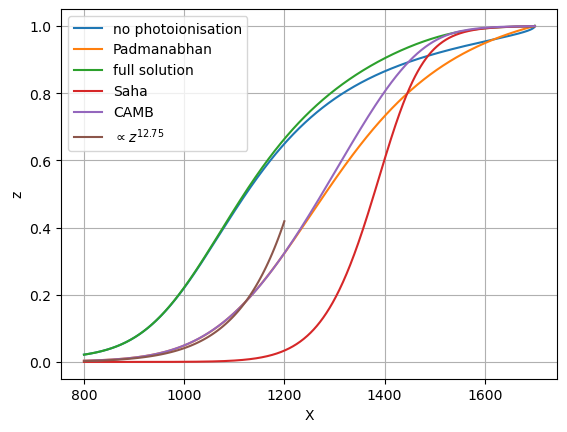

In [18]:
plt.plot(z, approx, label='no photoionisation')
plt.plot(z, vol3, label='Padmanabhan')
plt.plot(z, full, label='full solution')
plt.plot(z, saha(z), label='Saha')
plt.plot(z, cmb, label='CAMB')
plt.plot(trunc, review_fit, label='$\propto z^{12.75}$')
plt.legend()
plt.grid()
plt.xlabel('X')
plt.ylabel('z')
#plt.yscale('log')
plt.show()